# Assignment

In [46]:
from __future__ import absolute_import, division, print_function, unicode_literals

import tensorflow as tf

# You'll generate plots of attention in order to see which parts of an image
# our model focuses on during captioning
import matplotlib.pyplot as plt

import numpy as np
import time

In [2]:
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        # Currently, memory growth needs to be the same across GPUs
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
            tf.config.experimental.set_visible_devices(gpu, 'GPU')
        # Select GPU number 1
        # tf.config.experimental.set_visible_devices(gpus[0], 'GPU')
        tf.config.experimental.set_visible_devices(gpus[1], 'GPU')
        logical_gpus = tf.config.experimental.list_logical_devices('GPU')
        print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
    except RuntimeError as e:
        # Memory growth must be set before GPUs have been initialized
        print(e)

2 Physical GPUs, 1 Logical GPUs


In [3]:
!nvidia-smi

Wed Dec 15 23:53:42 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 465.19.01    Driver Version: 465.19.01    CUDA Version: 11.3     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA GeForce ...  Off  | 00000000:01:00.0 Off |                  N/A |
| 79%   73C    P8    28W / 250W |     21MiB / 11176MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
|   1  NVIDIA GeForce ...  Off  | 00000000:02:00.0 Off |                  N/A |
|  0%   

## Data Preprocess

In [4]:
CAPTION_FILE = './words_captcha/spec_train_val.txt'

In [5]:
def readDataset():
    caption = []
    with open(CAPTION_FILE) as f:
        for line in f.readlines():
            word = line.split()[1]
            caption.append([w for w in word])
    target = []
    for cap in caption:
        tmp = ''
        for i in range(len(cap)):
            tmp += f'{cap[i]} '
        target.append(f'<start> {tmp}<end>')
    return target

target = readDataset()

In [6]:
def imagePath():
    img_name = []
    for i in range(140000):
        img_name.append(f'./words_captcha/a{i}.png')
    return img_name

img_name_vec = imagePath()

In [7]:
print(target[:5])
print(img_name_vec[:5])
len(target), len(img_name_vec)

['<start> t h u s <end>', '<start> w w w <end>', '<start> t i e d <end>', '<start> i d s <end>', '<start> j a m <end>']
['./words_captcha/a0.png', './words_captcha/a1.png', './words_captcha/a2.png', './words_captcha/a3.png', './words_captcha/a4.png']


(120000, 140000)

In [8]:
# target_train, target_val = target[:100000], target[100000:]
img_train, img_val = img_name_vec[:100000], img_name_vec[100000: 120000]
img_test = img_name_vec[120000:]
len(img_train), len(img_val), len(img_test)

(100000, 20000, 20000)

### Preprocess and tokenize the captions

In [9]:
# Find the maximum length of any caption in our dataset
def calc_max_length(tensor):
    return max(len(t) for t in tensor)

In [10]:
# Choose the top 5000 words from the vocabulary
top_k = 5000
tokenizer = tf.keras.preprocessing.text.Tokenizer(num_words=top_k,
                                                  oov_token="<unk>",
                                                  filters='!"#$%&()*+.,-/:;=?@[\]^_`{|}~ ')
tokenizer.fit_on_texts(target)
train_seqs = tokenizer.texts_to_sequences(target)

tokenizer.word_index['<pad>'] = 0
tokenizer.index_word[0] = '<pad>'

# Create the tokenized vectors
train_seqs = tokenizer.texts_to_sequences(target)

cap_vector = tf.keras.preprocessing.sequence.pad_sequences(train_seqs, padding='post')

max_length = calc_max_length(train_seqs)

In [11]:
len(cap_vector)
target[0], train_seqs[0], cap_vector[0]

('<start> t h u s <end>',
 [2, 9, 18, 17, 6, 3],
 array([ 2,  9, 18, 17,  6,  3,  0], dtype=int32))

note: '\<start\>': 2, '\<end\>': 3

In [12]:
cap_train, cap_val = cap_vector[:100000], cap_vector[100000:]
len(cap_train), len(cap_val)

(100000, 20000)

### Create dataset

In [13]:
BATCH_SIZE = 32 # batch_size=32 occupy about 9G memory
BUFFER_SIZE = 5000
embedding_dim = 256
units = 512
vocab_size = len(tokenizer.word_index) + 1
num_steps = len(img_train) // BATCH_SIZE

features_shape = 2048
attention_features_shape = 64

In [14]:
# Load the numpy files
def map_fuc(image_path, annotation):
    img = tf.io.read_file(image_path)
    img = tf.image.decode_jpeg(img, channels=3)
    # resize height to 300, width to 160
    img = tf.image.resize(img, (300, 160))
    img = img / 255 - 1.
    return img, annotation

In [15]:
# Create training and valodation dataset
train_dataset = tf.data.Dataset.from_tensor_slices((img_train, cap_train))
train_dataset = train_dataset.map(
        map_fuc, num_parallel_calls=tf.data.experimental.AUTOTUNE
    )
train_dataset = train_dataset.shuffle(BUFFER_SIZE).batch(BATCH_SIZE)
train_dataset = train_dataset.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)


val_dataset = tf.data.Dataset.from_tensor_slices((img_val, cap_val))
val_dataset = val_dataset.map(
        map_fuc, num_parallel_calls=tf.data.experimental.AUTOTUNE
    )
val_dataset = val_dataset.shuffle(BUFFER_SIZE).batch(BATCH_SIZE)
val_dataset = val_dataset.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)

## Model

In [16]:
class conv_leaky_relu(tf.keras.layers.Layer):
    def __init__(self, filters, size, stride):
        super(conv_leaky_relu, self).__init__()
        self.conv = tf.keras.layers.Conv2D(filters, size, stride, padding="same",
                      kernel_initializer=tf.keras.initializers.TruncatedNormal())
        self.batchnorm = tf.keras.layers.BatchNormalization()
        self.lkrelu = tf.keras.layers.LeakyReLU(0.1)

    def call(self, inputs, training):
        x = self.conv(inputs)
        x = self.batchnorm(x,training = training)
        x = self.lkrelu(x)
        return x

### Use VGG19 as feature extracter

In [17]:
# VGG19
class Feature_Extracter(tf.keras.Model):

    def __init__(self):
        super(Feature_Extracter, self).__init__()
        self.cr1 = conv_leaky_relu(64, 3, 1)
        self.cr2 = conv_leaky_relu(64, 3, 1)
        self.max_pooling1 = tf.keras.layers.MaxPooling2D(pool_size=(2, 2), strides=(2, 2))
        self.cr3 = conv_leaky_relu(128, 3, 1)
        self.cr4 = conv_leaky_relu(128, 3, 1)
        self.max_pooling2 = tf.keras.layers.MaxPooling2D(pool_size=(2, 2), strides=(2, 2))
        self.cr5 = conv_leaky_relu(256, 3, 1)
        self.cr6 = conv_leaky_relu(256, 3, 1)
        self.cr7 = conv_leaky_relu(256, 3, 1)
        self.cr8 = conv_leaky_relu(256, 3, 1)
        self.max_pooling3 = tf.keras.layers.MaxPooling2D(pool_size=(2, 2), strides=(2, 2))
        self.cr9 = conv_leaky_relu(512, 3, 1)
        self.cr10 = conv_leaky_relu(512, 3, 1)
        self.cr11 = conv_leaky_relu(512, 3, 1)
        self.cr12 = conv_leaky_relu(512, 3, 1)
        self.max_pooling4 = tf.keras.layers.MaxPooling2D(pool_size=(2, 2), strides=(2, 2))
        self.cr13 = conv_leaky_relu(512, 3, 1)
        self.cr14 = conv_leaky_relu(512, 3, 1)
        self.cr15 = conv_leaky_relu(512, 3, 1)
        self.cr16 = conv_leaky_relu(512, 3, 1)

    def call(self, inputs, training):
        x = self.cr1(inputs,training)
        x = self.cr2(x,training)
        x = self.max_pooling1(x)
        x = self.cr3(x,training)
        x = self.cr4(x,training)
        x = self.max_pooling2(x)
        x = self.cr5(x,training)
        x = self.cr6(x,training)
        x = self.cr7(x,training)
        x = self.cr8(x,training)
        x = self.max_pooling3(x)
        x = self.cr9(x,training)
        x = self.cr10(x,training)
        x = self.cr11(x,training)
        x = self.cr12(x,training)
        x = self.max_pooling4(x)
        x = self.cr13(x,training)
        x = self.cr14(x,training)
        x = self.cr15(x,training)
        x = self.cr16(x,training)
        return x

In [18]:
class BahdanauAttention(tf.keras.Model):
    def __init__(self, units):
        super(BahdanauAttention, self).__init__()
        self.W1 = tf.keras.layers.Dense(units)
        self.W2 = tf.keras.layers.Dense(units)
        self.V = tf.keras.layers.Dense(1)

    def call(self, features, hidden):
        # features(CNN_encoder output) shape == (batch_size, 64, embedding_dim)

        # hidden shape == (batch_size, hidden_size)
        # hidden_with_time_axis shape == (batch_size, 1, hidden_size)
        hidden_with_time_axis = tf.expand_dims(hidden, 1)

        # score shape == (batch_size, 64, hidden_size)
        score = tf.nn.tanh(self.W1(features) + self.W2(hidden_with_time_axis))

        # attention_weights shape == (batch_size, 64, 1)
        # you get 1 at the last axis because you are applying score to self.V
        attention_weights = tf.nn.softmax(self.V(score), axis=1)

        # context_vector shape after sum == (batch_size, hidden_size)
        context_vector = attention_weights * features
        context_vector = tf.reduce_sum(context_vector, axis=1)

        return context_vector, attention_weights

In [19]:
class CNN_Encoder(tf.keras.Model):
    # Since you have already extracted the features and dumped it using pickle
    # This encoder passes those features through a Fully connected layer
    def __init__(self, embedding_dim):
        super(CNN_Encoder, self).__init__()
        # shape after fc == (batch_size, 64, embedding_dim)
        self.fc = tf.keras.layers.Dense(embedding_dim)

    def call(self, x):
        x = self.fc(x)
        x = tf.nn.relu(x)
        return x

In [20]:
class RNN_Decoder(tf.keras.Model):
    def __init__(self, embedding_dim, units, vocab_size):
        super(RNN_Decoder, self).__init__()
        self.units = units

        self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_dim)
        self.gru = tf.keras.layers.GRU(self.units,
                                       return_sequences=True,
                                       return_state=True,
                                       recurrent_initializer='glorot_uniform')
        self.fc1 = tf.keras.layers.Dense(self.units)
        self.fc2 = tf.keras.layers.Dense(vocab_size)

        self.attention = BahdanauAttention(self.units)

    def call(self, x, features, hidden):
        # defining attention as a separate model
        context_vector, attention_weights = self.attention(features, hidden)

        # x shape after passing through embedding == (batch_size, 1, embedding_dim)
        x = self.embedding(x)

        # x shape after concatenation == (batch_size, 1, embedding_dim + hidden_size)
        x = tf.concat([tf.expand_dims(context_vector, 1), x], axis=-1)

        # passing the concatenated vector to the GRU
        output, state = self.gru(x)

        # shape == (batch_size, max_length, hidden_size)
        x = self.fc1(output)

        # x shape == (batch_size * max_length, hidden_size)
        x = tf.reshape(x, (-1, x.shape[2]))

        # output shape == (batch_size * max_length, vocab)
        x = self.fc2(x)

        return x, state, attention_weights

    def reset_state(self, batch_size):
        return tf.zeros((batch_size, self.units))

In [21]:
feature_extracter = Feature_Extracter()
feature_extracter.build((None, 300, 160, 3))
feature_extracter.summary()

Model: "feature__extracter"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv_leaky_relu (conv_leaky  multiple                 2048      
 _relu)                                                          
                                                                 
 conv_leaky_relu_1 (conv_lea  multiple                 37184     
 ky_relu)                                                        
                                                                 
 max_pooling2d (MaxPooling2D  multiple                 0         
 )                                                               
                                                                 
 conv_leaky_relu_2 (conv_lea  multiple                 74368     
 ky_relu)                                                        
                                                                 
 conv_leaky_relu_3 (conv_lea  multiple          

In [22]:
encoder = CNN_Encoder(embedding_dim)
decoder = RNN_Decoder(embedding_dim, units, vocab_size)

In [23]:
optimizer = tf.keras.optimizers.Adam()
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(
    from_logits=True, reduction='none')

def loss_function(real, pred):
    mask = tf.math.logical_not(tf.math.equal(real, 0))
    loss_ = loss_object(real, pred)

    mask = tf.cast(mask, dtype=loss_.dtype)
    loss_ *= mask

    return tf.reduce_mean(loss_)

In [24]:
checkpoint_path = "./checkpoints/vgg19"
ckpt = tf.train.Checkpoint(encoder=encoder,
                           decoder=decoder,
                           optimizer = optimizer)
ckpt_manager = tf.train.CheckpointManager(ckpt, checkpoint_path, max_to_keep=5)

In [25]:
start_epoch = 0
if ckpt_manager.latest_checkpoint:
    start_epoch = int(ckpt_manager.latest_checkpoint.split('-')[-1])
print(start_epoch)

0


## Training
Instead of saving image features as numpy file, I modified pipeline a little to achieve end-to-end training.

In [26]:
# adding this in a separate cell because if you run the training cell
# many times, the loss_plot array will be reset
loss_plot = []

In [27]:
@tf.function
def train_step(img_tensor, target):
    loss = 0

    # initializing the hidden state for each batch
    # because the captions are not related from image to image
    hidden = decoder.reset_state(batch_size=target.shape[0])
    dec_input = tf.expand_dims([tokenizer.word_index['<start>']] * BATCH_SIZE, 1)

    with tf.GradientTape() as tape:
        features = feature_extracter(img_tensor, True)
        features = tf.reshape(features,(features.shape[0], -1, features.shape[3]))
        features = encoder(features)

        for i in range(1, target.shape[1]):
            # passing the features through the decoder
            predictions, hidden, _ = decoder(dec_input, features, hidden)

            loss += loss_function(target[:, i], predictions)

            # using teacher forcing
            dec_input = tf.expand_dims(target[:, i], 1)

    total_loss = (loss / int(target.shape[1]))
    trainable_variables = feature_extracter.trainable_variables + encoder.trainable_variables + decoder.trainable_variables
    gradients = tape.gradient(loss, trainable_variables)
    optimizer.apply_gradients(zip(gradients, trainable_variables))

    return loss, total_loss

In [28]:
EPOCHS = 10

for epoch in range(start_epoch, EPOCHS):
    start = time.time()
    total_loss = 0

    for (batch, (img_tensor, target)) in enumerate(train_dataset):
        batch_loss, t_loss = train_step(img_tensor, target)
        total_loss += t_loss
        
    # storing the epoch end loss value to plot later
    loss_plot.append(total_loss / num_steps)

    if epoch % 2 == 0:
        ckpt_manager.save()

    print ('Epoch {} Loss {:.6f}'.format(epoch + 1,
                                         total_loss/num_steps))
    print ('Time taken for 1 epoch {} sec\n'.format(time.time() - start))

Epoch 1 Loss 1.385035
Time taken for 1 epoch 1026.052608013153 sec

Epoch 2 Loss 0.184486
Time taken for 1 epoch 1018.3076481819153 sec

Epoch 3 Loss 0.032097
Time taken for 1 epoch 1017.7049744129181 sec

Epoch 4 Loss 0.019288
Time taken for 1 epoch 1018.9943478107452 sec

Epoch 5 Loss 0.015148
Time taken for 1 epoch 1018.0390944480896 sec

Epoch 6 Loss 0.011030
Time taken for 1 epoch 1018.7507247924805 sec

Epoch 7 Loss 0.009985
Time taken for 1 epoch 1018.4691143035889 sec

Epoch 8 Loss 0.008267
Time taken for 1 epoch 1018.4540584087372 sec

Epoch 9 Loss 0.009373
Time taken for 1 epoch 1018.5190284252167 sec

Epoch 10 Loss 0.007217
Time taken for 1 epoch 1019.4814200401306 sec



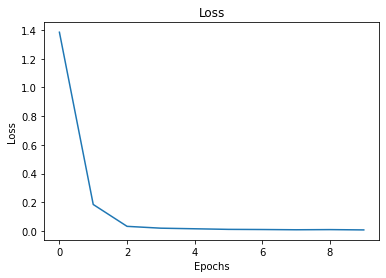

In [29]:
plt.plot(loss_plot)
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss')
plt.show()

## Validation

In [66]:
def evaluate(image):
    hidden = decoder.reset_state(batch_size=BATCH_SIZE)
    dec_input = tf.expand_dims([tokenizer.word_index['<start>']] * BATCH_SIZE, 1)

    features = feature_extracter(image,False)
    features = tf.reshape(features,(features.shape[0], -1, features.shape[3]))
    features = encoder(features)

    result = np.full((BATCH_SIZE, 1), 2) # full with '<start>'
    for i in range(1, max_length):
        # passing the features through the decoder
        predictions, hidden, _ = decoder(dec_input, features, hidden)
        predicted_id = tf.argmax(predictions,axis=1).numpy()
        result = np.concatenate((result, predicted_id.reshape((BATCH_SIZE,1))), axis=1)
        dec_input = tf.expand_dims(predicted_id, 1)

    return result

In [55]:
def post_processing(pred):
    pred_str = []
    for i in range(len(pred)):
        tmpstr = ''
        for j in range(1, len(pred[i])):
            if pred[i][j] == 3: # encounter '<end>'
                break
            tmpstr += tokenizer.index_word[pred[i][j]]
        pred_str.append(tmpstr)
    return pred_str

In [61]:
error = 0
for (batch, (img_tensor, target)) in enumerate(val_dataset):
    pred = evaluate(img_tensor)
    pred_str = post_processing(pred)
    target_str = post_processing(target.numpy())

    for i in range(BATCH_SIZE):
        if pred_str[i] != target_str[i]:
            error += 1
    
    print(f'{batch+1:2d}, Val. Accuracy: {1 - float(error) / ((batch+1)*BATCH_SIZE)}', end='\r')

## Testing

In [62]:
def map_test(image_path):
    img = tf.io.read_file(image_path)
    img = tf.image.decode_jpeg(img, channels=3)
    # resize height to 300, width to 160
    img = tf.image.resize(img, (300, 160))
    img = img / 255 - 1.
    return img

In [73]:
test_dataset = tf.data.Dataset.from_tensor_slices((img_test))
test_dataset = test_dataset.map(
        map_test, num_parallel_calls=tf.data.experimental.AUTOTUNE
    )
test_dataset = test_dataset.batch(BATCH_SIZE)
test_dataset = test_dataset.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)

In [77]:
with open('Lab13-2_110065512.txt', 'w') as f:
    for (batch, (img_tensor)) in enumerate(test_dataset):
        pred = evaluate(img_tensor)
        pred_str = post_processing(pred)
        for i in range(len(pred_str)):
            line = f'a{120000 + batch*BATCH_SIZE + i} {pred_str[i]}\n'
            f.write(line)

# Report
* Overall pipeline: Feature Extracter(VGG19) -> Encoder -> Decoder(GRU)
* I tried using pre-trained model, i.e. VGG19 and InceptionV3, as feature extracter but got poor performance.
* Validation accuracy: 99.59%